In [1]:
import os, glob, pdb
import operator
import numpy
import iris
import iris.coord_categorisation
import sklearn.isotonic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

import scipy
import matplotlib.pyplot as plt
import matplotlib

from qumpy_lite import *
# from qumpy.irislib.downscaler import butterworth



def gp_smoother(y, max_length=10.0): 
    
    x = numpy.arange(y.size)
    xx = ((x - x[0]) / float(x.ptp())).reshape((-1, 1))
    ydash = butterworth(y, 10.0, high_pass=True)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xx.ravel(), y)
    residual = y - intercept - slope * xx.ravel()
    yvar = ydash.var()
    kernel = Matern(nu=2.5, length_scale=1.0, length_scale_bounds=(0.3, max_length)) + \
             WhiteKernel(noise_level=yvar, noise_level_bounds=(yvar * 1e-5, yvar * 2))

    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=False)
    gp.fit(xx, residual)
    ypred = gp.predict(xx, return_std=False) + intercept + slope * xx.ravel()
#     print(gp.kernel_)
    return ypred

def anom_pd(x):
    if x.ndim == 1:
        return x - x[80:110].mean()
    else:
        return (x.T - x[:,80:110].mean(1)).T
    
def anom_late21(x):
    x = anom_pd(x)
    if x.ndim == 1:
        return x[-30:].mean()
    else:
        return x[:,-30:].mean(1)



%matplotlib inline

In [2]:
if True:
    current = os.getcwd()
    parent = os.path.dirname(current)
    sys.path.insert(0, parent)
    from paths import *
else:
    from paths import *

searchstr = os.path.join(coupleddir, 'UK', 'histrcp8p5_%s_uk.nc')
cachedir = os.path.join(tempdir, 'cache', 'wt_jets')
figpath = os.path.join(plotdir, 'paper_ukwinter_precip')
jets_dir = os.path.join(coupleddir, 'jets', 'gcm_jets')

print(cmipdir)


In parent directory
/Users/davidsexton/Data/papers/uk_winter_precip/coupled/cmip6


In [3]:
# f = os.path.join(globaldir, 'histrcp8p5_tas_global_annual.nc')
# gst = iris.load_cube(f)
# print(gst)
# gsta = (gst.data.T - gst.data[:,:50].mean(1)).T
# years = gst.coord('season_year').points

In [4]:
indir_zonal = os.path.join(coupleddir, 'zonal')

 
#centaur.reading.ac.uk/70531/8/jcli-d-16-0807.1.pdf
#   * polar warming (DTpolar): temperature change at 850 hPa averaged between 60 and 90N,
#   * tropical warming (DTtrop): temperature change at 250 hPa averaged between 30S and 30N, and
#   * stratospheric vortex strength (DUstrat): zonal mean zonal-wind change at 20 hPa averaged between 70 and 80N
 
def get_data(var, latlo, lathi, months='DJFMAMJJASON'):
#    var, latlo, lathi, months = 'ta850', 60, 90, 'NDJFMA'
    seasonal_averager = MonthMean(months)
    lat_crit = iris.Constraint(latitude=iris.util.between(latlo, lathi))
    f = os.path.join(indir_zonal, 'histrcp8p5_%s_zonal.nc' % var)
    cube = iris.load_cube(f, lat_crit)
    cube = cube.collapsed('latitude', iris.analysis.MEAN)
    d = cube.data
    absol = seasonal_averager(cube)
    ans = absol.copy()
    years = ans.coord('season_year').points
    ind = numpy.where((years > 1980) & (years < 2001))[0]
    ind = numpy.where((years > 1900) & (years < 1951))[0]
    ans.data = (ans.data.T - ans.data[:,ind].mean(-1)).T
    return ans, absol
 
 
DTglobal = get_data('tas', -90, 90)
DTpolar_zappa, Tpolar_zappa = get_data('ta850', 60, 90, months='NDJFMA')
DTtrop_zappa, Ttrop_zappa = get_data('ta250', -30, 30, months='NDJFMA')
DUstrat_zappa, Ustrat_zappa = get_data('ua020', 70, 80, months='NDJFMA')


/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn

In [5]:
def get_control_data(var, latlo, lathi, months='DJFMAMJJASON'):
#    var, latlo, lathi, months = 'ta850', 60, 90, 'NDJFMA'
    seasonal_averager = MonthMean(months)
    lat_crit = iris.Constraint(latitude=iris.util.between(latlo, lathi))
    indir_zonal = os.path.join(coupleddir, 'control_zonal')
    f = os.path.join(indir_zonal, '%s*zonal.nc' % var)
    cube = iris.load_cube(f, lat_crit)
    cube = cube.collapsed('latitude', iris.analysis.MEAN)
    d = cube.data
    cube.coord('time').bounds = None
    for fc in ['forecast_period', 'forecast_reference_time']:
        if cube.coords(fc):
            cube.remove_coord(fc)
    absol = seasonal_averager(cube)
    ans = absol.copy()
    years = ans.coord('season_year').points
    ind = numpy.where((years > 1980) & (years < 2001))[0]
    ind = numpy.where((years > 1900) & (years < 1951))[0]
    ans.data = (ans.data.T - ans.data[:,ind].mean(-1)).T
    return ans, absol
 
 
# DTglobal = get_data('tas', -90, 90)
# DTpolar_zappa, Tpolar_zappa = get_data('ta850', 60, 90, months='NDJFMA')
# DTtrop_zappa, Ttrop_zappa = get_data('ta250', -30, 30, months='NDJFMA')
DUstrat_zappa_control, Ustrat_zappa_control = get_control_data('ua020', 70, 80, months='NDJFMA')
DTpolar_zappa_control, Tpolar_zappa_control = get_control_data('ta850', 60, 90, months='NDJFMA')
DTtrop_zappa_control, Ttrop_zappa_control = get_control_data('ta250', -30, 30, months='NDJFMA')
Dqbo_control, qbo_control = get_control_data('ua020', -10, 10, months='DJFMAMJJASON')



DUstrat_zappa_control, Ustrat_zappa_control, qbo_control

/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn

(<iris 'Cube' of x_wind / (m s-1) (realization: 19; time: 169)>,
 <iris 'Cube' of x_wind / (m s-1) (realization: 19; time: 169)>,
 <iris 'Cube' of x_wind / (m s-1) (realization: 19; time: 170)>)

In [6]:
DQtrop, Qtrop = get_data('hus070', -20, 20, months='NDJFMA')
DTpause, Tpause = get_data('ta100', -20, 20, months='NDJFMA')

/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


In [7]:
DTpolar_zappa_anti, Tpolar_zappa_anti = get_data('ta850', -30, 30, months='NDJFMA')
DTtrop_zappa_anti, Ttrop_zappa_anti = get_data('ta250', 60, 90, months='NDJFMA')

DTpolar_grad = DTpolar_zappa_anti - DTpolar_zappa
DTtrop_grad = DTtrop_zappa - DTtrop_zappa_anti

/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


In [8]:
jet_lat = iris.load_cube(os.path.join(cachedir, 'jets_djf.nc'), 'jet latitude')
jet_str = iris.load_cube(os.path.join(cachedir, 'jets_djf.nc'), 'jet strength')





In [9]:
Dqbo, qbo = get_data('ua020', -10, 10, months='DJFMAMJJASON')
print(jet_lat, qbo, Ttrop_zappa, Tpolar_zappa, Ustrat_zappa)




/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


jet latitude / (degrees)            (realization: 20; time: 17970)
    Dimension coordinates:
        realization                             x         -
        time                                    -         x
    Auxiliary coordinates:
        month                                   -         x
        month_number                            -         x
        season                                  -         x
        season_year                             -         x
        year                                    -         x
        yyyymmdd                                -         x
    Scalar coordinates:
        forecast_reference_time     1896-12-01 00:00:00
        latitude                    42.500003814697266 degrees, bound=(15.000007629394531, 70.0) degrees
        longitude                   -30.000002548098564 degrees, bound=(-60.41667175292969, 0.4166666567325592) degrees
        pressure                    850.0 hPa
    Cell methods:
        mean                  

In [10]:
def anom(x):
    if x.ndim == 1:
        return x - x[:50].mean()
    else:
        return (x.T - x[:,:50].mean(1)).T

def make_plot(cube, titl, year_coord='season_year', make_anom=True, filter=True,
              drop=(1100090, 1102089, 1102753, 1102884, 1102914),
              colors=('DodgerBlue', 'b'), drop_color='Lime',
              max_length=1.5,
              nrow=1, ncol=2, ipanel=1):
        
    if make_anom:
        cube = cube.copy(data=anom(cube.data))
    if filter:
        filt = numpy.apply_along_axis(gp_smoother, -1, cube.data, max_length=max_length)
        cube = cube.copy(data=filt)
        titl += '\n(smoothed)'
    
    if drop is not None:
        rcoord = cube.coord('realization')
        new_coord = rcoord.copy(points=[ip for ip in rcoord.points if ip in drop])
        cube_ = cube.subset(new_coord)

    
    years2 = cube.coord(year_coord).points
    plt.subplot(nrow, ncol, ipanel)
    plts = plt.plot(years2, cube.data.T, color=colors[0], linewidth=0.5)
    if drop is not None:
        plt2 = plt.plot(years2, cube_.data.T, color=drop_color, linewidth=0.5)
        plt.plot(years2, cube_.data.mean(0), color=drop_color, linewidth=2)
    plt.plot(years2, cube.data.mean(0), color=colors[1], linewidth=1.5)
    plt.title(titl)
    



In [11]:
def delta2(x):
    return x[:,-30:].mean(-1) - x[:,:50].mean(-1)



In [12]:
KEEP = [1100000, 1100605, 1100834, 1101113, 1101554, 1101649,
        1101843, 1101935, 1102123, 1102242,
        1102305, 1102335, 1102491, 1102832, 1102868]
DROP = [1100090, 1102089, 1102753, 1102884, 1102914]

rcrit = iris.Constraint(realization=KEEP)
iok = [Ustrat_zappa.coord('realization').points.tolist().index(ii) for ii in KEEP]



control shape (13, 169)
control shape (13, 169)
control shape (13, 169)


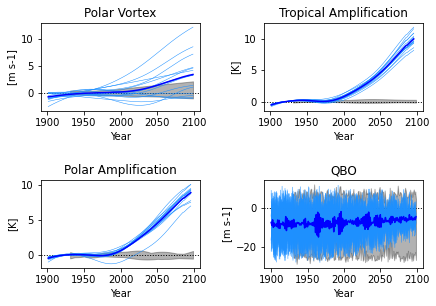

In [13]:
def make_plot(cube, titl, year_coord='season_year', make_anom=True, filter=True, control=None,
              drop=(1100090, 1102089, 1102753, 1102884, 1102914),
              cntl_drop=(1100090, 1102089, 1102305, 1102335, 1102753, 1102884, 1102914),
              colors=('DodgerBlue', 'b'), drop_color='Lime',
              max_length=1.5,
              nrow=1, ncol=2, ipanel=1):
    
    import warnings
    with warnings.catch_warnings():
    # this will suppress all warnings in this block
        warnings.simplefilter("ignore")

        if make_anom:
            cube = cube.copy(data=anom(cube.data))
        if filter:
            filt = numpy.apply_along_axis(gp_smoother, -1, cube.data, max_length=max_length)
            cube = cube.copy(data=filt)
    #         titl += '\n(smoothed)'

        if drop is not None:
            rcoord = cube.coord('realization')
            new_coord = rcoord.copy(points=[ip for ip in rcoord.points if ip in drop])
            cube_ = cube.subset(new_coord)


        years2 = cube.coord(year_coord).points
        plt.subplot(nrow, ncol, ipanel)
        plt.axhline(y=0, linewidth=1, color='k', linestyle=':')

        if control is not None:
            rcoord = cube.coord('realization')
    #         cntl_drop = (1100090, 1102089, 1102305, 1102335, 1102753, 1102884, 1102914)
            new_coord = rcoord.copy(points=[ip for ip in rcoord.points if ip not in cntl_drop])
            control_cube = control.subset(new_coord)

            yearsc = control.coord(year_coord).points
            if make_anom:
                control_cube.data = anom(control_cube.data)

            if filter:
                control_filt = numpy.apply_along_axis(gp_smoother, -1, control_cube.data, max_length=max_length)
                control_cube = control_cube.copy(data=control_filt) 
                print('control shape', control_cube.shape)
    #         pltc = plt.plot(yearsc, control_cube.data.T, color='purple', linewidth=0.5)
            pltc = plt.fill_between(yearsc, control_cube.data.min(0), y2=control_cube.data.max(0), color='k', alpha=0.3)

        plts = plt.plot(years2, cube.data.T, color=colors[0], linewidth=0.5)
        if drop is not None:
            plt2 = plt.plot(years2, cube_.data.T, color=drop_color, linewidth=0.5)
            plt.plot(years2, cube_.data.mean(0), color=drop_color, linewidth=2)
        plt.plot(years2, cube.data.mean(0), color=colors[1], linewidth=1.5)
        plt.title(titl)
        plt.xlabel('Year')
        plt.ylabel('[%s]' % cube.units)


    #     plt.subplot(nrow, ncol, ipanel + 1)
    #     plt.plot(years2, cube.data.std(0), color=colors[1])
    #     if drop is not None:
    #         plt.plot(years2, cube_.data.std(0), color=drop_color)
    #     plt.title(titl + '\nEnsemble spread')


fig = plt.figure(figsize=(174/25.4, 4.5))
plt.subplots_adjust(hspace=0.8, wspace=0.4)
make_plot(Ustrat_zappa.extract(rcrit), 'Polar Vortex', year_coord='season_year', control=Ustrat_zappa_control,
          colors=('DodgerBlue', 'b'), drop_color='DodgerBlue', drop=None, max_length=1, ipanel=1, nrow=2, ncol=2)
# plt.fill_between(Ustrat_zappa_control)

make_plot(Tpolar_zappa.extract(rcrit), 'Polar Amplification', year_coord='season_year', control=Tpolar_zappa_control,
          colors=('DodgerBlue', 'b'), drop_color='DodgerBlue', drop=None, max_length=1, ipanel=3, nrow=2, ncol=2)

make_plot(Ttrop_zappa.extract(rcrit), 'Tropical Amplification', year_coord='season_year', control=Ttrop_zappa_control,
          colors=('DodgerBlue', 'b'), drop_color='DodgerBlue', drop=None, max_length=1, ipanel=2, nrow=2, ncol=2)

make_plot(qbo.extract(rcrit), 'QBO', year_coord='season_year', control=qbo_control,
          colors=('DodgerBlue', 'b'), drop_color='DodgerBlue', drop=None, max_length=0.3, ipanel=4, nrow=2,
          ncol=2, make_anom=False, filter=False)


# make_plot(Ustrat_zappa, 'Polar Vortex', year_coord='season_year', colors=('orange', 'r'), drop_color='lime')

# figpath = os.path.join(/wt_jets_figures'

fig.savefig(os.path.join(figpath, 'zappa_DJF_timeseries.png'), dpi=300, facecolor='w')
fig.savefig(os.path.join(figpath, 'Fig9.png'), dpi=300, facecolor='w')
fig.savefig(os.path.join(figpath, 'Fig9.tiff'), facecolor='w')




In [14]:
# def read_index(indir, expt, var):
#     '''e.g. n34_spin = read_index(indir, 'ppe_spinup', 'nino3.4')
       
#     '''
    
#     def can_keep(f):
#         DROPPED = ['r001i1p00103', 'r001i1p02549', 'r001i1p00696', 'r001i1p02829', 'r001i1p00939']
#         return all([d not in f for d in DROPPED])
    
    
#     allowed_vars = ['nino3.4', 'amo', 'pdo', 'amoc']
#     if var not in allowed_vars:
#         raise ValueError('var %s is not allowed' % var)
#     files = sorted(glob.glob(os.path.join(indir, 'indices', expt, var, '*.nc')))
#     if var == 'amoc':
#         files = [f for f in files if not ('_34s.nc' in f or '_50n.nc' in f)]
#     cubelist = iris.cube.CubeList([iris.load_cube(f) for f in files if can_keep(f)])
    
#     for c in cubelist:
#         if not c.coords('month'):
#             iris.coord_categorisation.add_month(c, 'time')
#         if not c.coords('year'):
#             iris.coord_categorisation.add_year(c, 'time')
#             c.coord('year').attributes = None
            
#     def _make_annual_if_needed(c):
# #         print c.coord('month').shape, numpy.unique(c.coord('month').points)
#         if numpy.unique(c.coord('month').points).size > 1:
#             ANNUAL = MonthMean('DJFMAMJJASON')
#             annual = ANNUAL(c)
#             if annual.coords('season_year'):
#                 annual.remove_coord('year')
#                 annual.coord('season_year').rename('year')
#             return annual
#         else:
#             return c
    
#     cubelist = iris.cube.CubeList([_make_annual_if_needed(c) for c in cubelist])
            
#     return cubelist

# def combine_expts(*cubelists):
#     from functools import reduce
#     all_cubes = reduce(operator.add, cubelists)
#     realns = sorted(set([i.coord('realization').points[0] for i in all_cubes]))
#     merged = [split_and_merge('time', all_cubes.extract(iris.Constraint(realization=r))) for r in realns]
#     merged = [c.copy(data=numpy.ma.array(c.data, numpy.float32)) for c in merged]
#     return iris.cube.CubeList(merged)




# def merge_over_coord(cubelist, coord):
#     common_coord = cubelist[0].coord(coord)
#     for i in cubelist[1:]:
#         common_coord = common_coord.intersect(i.coord(coord))
#     cubelist_sub = iris.cube.CubeList([i.subset(common_coord) for i in cubelist])
#     for i in cubelist_sub:
#         del i.attributes['history']
#     ans = cubelist_sub.merge_cube()
#     return ans




In [15]:

def delta(x):
    return x[:,-50:].mean(-1) - x[:,:50].mean(-1)


def clim(x):
    return x[:,70:100].mean(-1)



In [16]:
# this plot shows that 64% of polar vortex variance in OK runs can be predicted from AMIP response to warmer SSTs
# K-B sea ice changes. The changes depend completely on climatological values, not clearly related to AMOC. So 
# something else in runs is driving K-B sea ice.
# They don't add in quadrature so some correlation
# It is not ozone tropopause related by lack of correlation with strat water vapour across PPE
# There is an offset - not sure what that is.

# correlation below suggest nsigma plays a role in determining kara-barents sea ice

def deltaN(x, N=20):
    print('deltaN', x.shape)
    if x.ndim == 2:
        return x[:,-N:].mean(-1) - x[:,:50].mean(-1)
    else:
        return x[-N:].mean() - x[:50].mean()





/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:728: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas = numpy.linalg.lstsq(x.T, y)[0]
/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:768: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[slicer]
/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:728: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcon

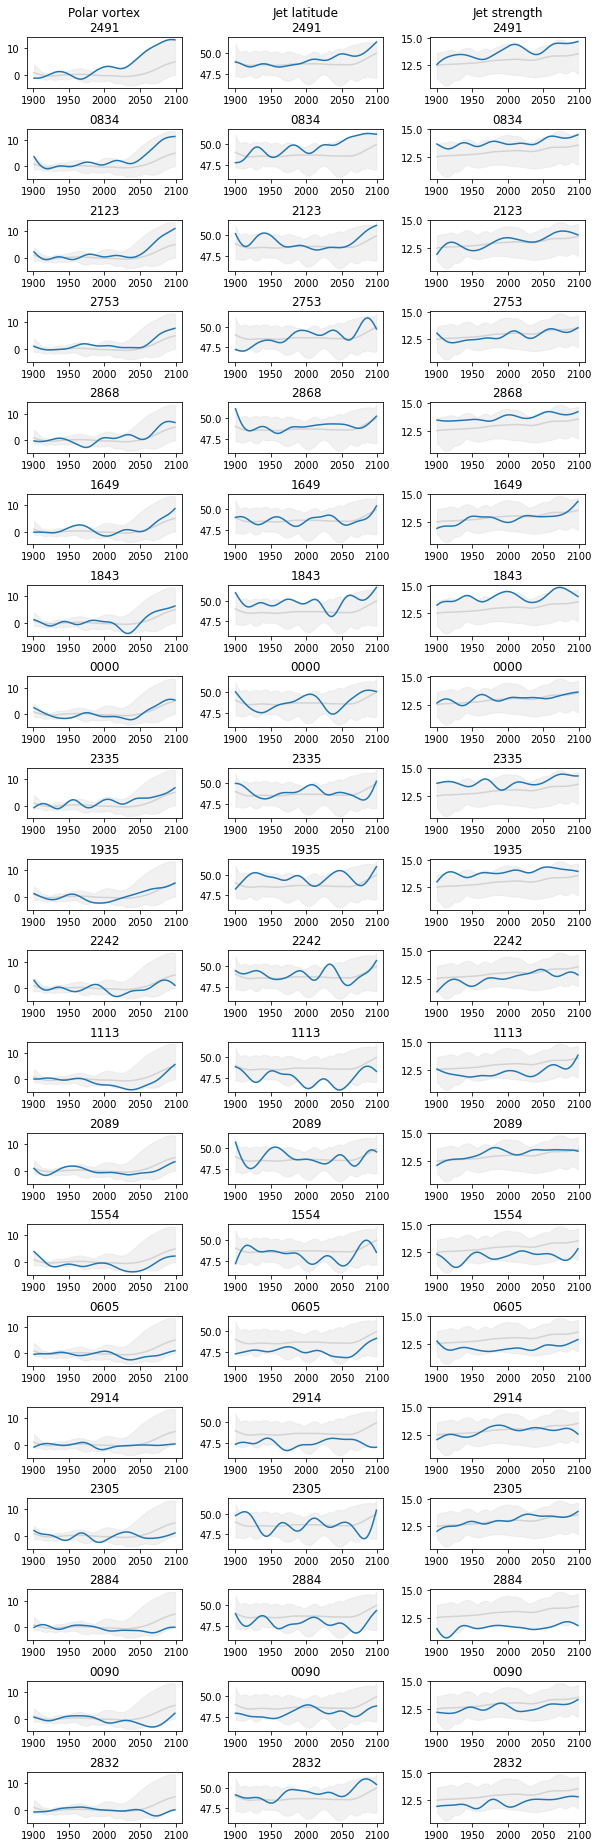

In [17]:
# indicator = DUstrat_zappa.copy(data=numpy.apply_along_axis(gp_smoother, -1, DUstrat_zappa.data, max_length=0.8))
# interannual_jet_posn = jet_lat.aggregated_by('season_year', iris.analysis.MEAN)                               
# quantity = interannual_jet_posn.copy(data=numpy.apply_along_axis(gp_smoother, -1, interannual_jet_posn.data, max_length=0.8))

period = 40.0
indicator = DUstrat_zappa.copy(data=butterworth(DUstrat_zappa.data, period, m=20))

interannual_jet_posn = jet_lat.aggregated_by('season_year', iris.analysis.MEAN)
                               
quantity = interannual_jet_posn.copy(data=butterworth(interannual_jet_posn.data, period, m=20))

interannual_jet_str = jet_str.aggregated_by('season_year', iris.analysis.MEAN)
                               
quantity2 = interannual_jet_str.copy(data=butterworth(interannual_jet_str.data, period, m=20))



srt = numpy.argsort(indicator.data[:,-30:].mean(-1))[::-1]


fig = plt.figure(figsize=(10, 32))
plt.subplots_adjust(hspace=0.8, wspace=0.3, top=0.9)
for i0, i1 in enumerate(srt):
    if i0 == 0:
        prefixes = ('Polar vortex\n', 'Jet latitude\n', 'Jet strength\n')
    else:
        prefixes = [''] * 3
    plt.subplot(20, 3, i0 * 3 +1)
    xx = indicator.coord('season_year').points
    plt.fill_between(xx, indicator.data.min(0), indicator.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, indicator.data.mean(0), color='LightGray')
    plt.plot(xx, indicator.data[i1])
    titl = '%.4i' % (indicator.coord('realization').points[i1] - 1100000)
    plt.title(prefixes[0] + titl)
    
    plt.subplot(20, 3, i0 * 3 +2)
    xx = quantity.coord('season_year').points
    plt.fill_between(xx, quantity.data.min(0), quantity.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, quantity.data.mean(0), color='LightGray')
    plt.plot(xx, quantity.data[i1])
    plt.title(prefixes[1] + titl)

    plt.subplot(20, 3, i0 * 3 +3)
    xx = quantity2.coord('season_year').points
    plt.fill_between(xx, quantity2.data.min(0), quantity2.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, quantity2.data.mean(0), color='LightGray')
    plt.plot(xx, quantity2.data[i1])
    plt.title(prefixes[2] + titl)

    



CMIP6 comparison
=============


In [54]:

def get_cmip6(var):
    files = glob.glob(os.path.join(cmipdir, '*/*/*/%s.nc' % var))
    cubes = dict()
    for f in files:
        info = institution, model, rip = os.path.dirname(f).split('/')[-3:]
        key = '/'.join(info)
        cubes[key] = iris.load_cube(f)
    return cubes

print(cmipdir)
cmip6_thi = get_cmip6('thi')
cmip6_spv = get_cmip6('spv')
cmip6_spv.keys()


/Users/davidsexton/Data/papers/uk_winter_precip/coupled/cmip6


dict_keys(['CAS/CAS-ESM2-0/r1i1p1f1', 'CAS/FGOALS-g3/r1i1p1f1', 'UA/MCM-UA-1-0/r1i1p1f2', 'NCC/NorESM2-LM/r1i1p1f1', 'NCC/NorESM2-MM/r1i1p1f1', 'CSIRO/ACCESS-ESM1-5/r1i1p1f1', 'MIROC/MIROC6/r1i1p1f1', 'MIROC/MIROC-ES2L/r1i1p1f2', 'NCAR/CESM2/r1i1p1f1', 'NCAR/CESM2-WACCM/r1i1p1f1', 'FIO-QLNM/FIO-ESM-2-0/r1i1p1f1', 'CCCR-IITM/IITM-ESM/r1i1p1f1', 'CMCC/CMCC-ESM2/r1i1p1f1', 'CMCC/CMCC-CM2-SR5/r1i1p1f1', 'BCC/BCC-CSM2-MR/r1i1p1f1', 'MOHC/HadGEM3-GC31-LL/r1i1p1f3', 'MOHC/UKESM1-0-LL/r1i1p1f2', 'MOHC/HadGEM3-GC31-MM/r1i1p1f3', 'MRI/MRI-ESM2-0/r1i1p1f1', 'CSIRO-ARCCSS/ACCESS-CM2/r1i1p1f1', 'AWI/AWI-CM-1-1-MR/r1i1p1f1', 'CAMS/CAMS-CSM1-0/r1i1p1f1', 'NASA-GISS/GISS-E2-1-G/r1i1p1f2', 'AS-RCEC/TaiESM1/r1i1p1f1', 'CCCma/CanESM5/r1i1p1f1', 'MPI-M/MPI-ESM1-2-HR/r1i1p1f1', 'MPI-M/MPI-ESM1-2-LR/r1i1p1f1', 'NUIST/NESM3/r1i1p1f1'])

In [55]:
# !ls {cmipdir}/*/*/*

In [56]:
delta(DUstrat_zappa.data)
delta(Ttrop_zappa.data)



masked_array(data=[6.879102783203109, 6.381533610025997, 6.86501342773434,
                   7.696797688802064, 7.951996663411478,
                   6.352103271484452, 7.432496337890626,
                   6.807379557291682, 6.188810221354146,
                   6.557980550130196, 7.778398030599021,
                   6.824227701822906, 7.1200166829426905,
                   5.712671305338517, 6.935825195312475,
                   6.777924804687501, 8.495408528645783,
                   6.864757080078192, 6.917567545572922,
                   5.730756835937456],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

In [57]:
iok
DTtrop_zappa.data[iok].shape


(15, 195)

In [58]:
cmip6_thi

{'CAS/CAS-ESM2-0/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'CAS/FGOALS-g3/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 249)>,
 'UA/MCM-UA-1-0/r1i1p1f2': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'NCC/NorESM2-LM/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'NCC/NorESM2-MM/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'CSIRO/ACCESS-ESM1-5/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'MIROC/MIROC6/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'MIROC/MIROC-ES2L/r1i1p1f2': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'NCAR/CESM2-WACCM/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'FIO-QLNM/FIO-ESM-2-0/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'CCCR-IITM/IITM-ESM/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 249)>,
 'CMCC/CMCC-ESM2/r1i1p1f1': <iris 'Cube' of air_temperature / (K) (time: 250)>,
 'CMCC/CMCC-CM2-SR5/r1i1p

['NCAR/CESM2-WACCM/r1i1p1f1', 'CSIRO/ACCESS-ESM1-5/r1i1p1f1', 'NUIST/NESM3/r1i1p1f1', 'CAS/CAS-ESM2-0/r1i1p1f1', 'MOHC/HadGEM3-GC31-MM/r1i1p1f3', 'MOHC/HadGEM3-GC31-LL/r1i1p1f3', 'AWI/AWI-CM-1-1-MR/r1i1p1f1', 'CSIRO-ARCCSS/ACCESS-CM2/r1i1p1f1', 'NCC/NorESM2-MM/r1i1p1f1', 'FIO-QLNM/FIO-ESM-2-0/r1i1p1f1', 'NASA-GISS/GISS-E2-1-G/r1i1p1f2', 'CCCma/CanESM5/r1i1p1f1', 'CAS/FGOALS-g3/r1i1p1f1', 'MOHC/UKESM1-0-LL/r1i1p1f2', 'MIROC/MIROC6/r1i1p1f1', 'MPI-M/MPI-ESM1-2-HR/r1i1p1f1', 'CCCR-IITM/IITM-ESM/r1i1p1f1', 'UA/MCM-UA-1-0/r1i1p1f2', 'MPI-M/MPI-ESM1-2-LR/r1i1p1f1', 'CMCC/CMCC-CM2-SR5/r1i1p1f1', 'BCC/BCC-CSM2-MR/r1i1p1f1', 'MRI/MRI-ESM2-0/r1i1p1f1', 'NCC/NorESM2-LM/r1i1p1f1', 'CMCC/CMCC-ESM2/r1i1p1f1', 'MIROC/MIROC-ES2L/r1i1p1f2', 'AS-RCEC/TaiESM1/r1i1p1f1', 'CAMS/CAMS-CSM1-0/r1i1p1f1']
10.0
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (130,)
deltaN (

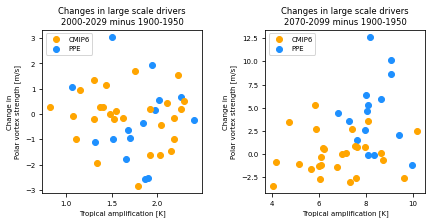

In [59]:
cmip6_models = list(set(list(cmip6_thi.keys())).intersection(list(cmip6_spv.keys())))
print(cmip6_models)
len(cmip6_models)

print(matplotlib.rcParams['font.size'])
fs = matplotlib.rcParams['font.size']

matplotlib.rcParams['font.size'] = 7

fig = plt.figure(figsize=(174/25.4, 3))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
label = None
for cm in cmip6_models:
#     print(cm)
    xx = deltaN(cmip6_thi[cm][50:180].data, N=30)
    yy = deltaN(cmip6_spv[cm][50:180].data, N=30)
    if cm == cmip6_models[-1]:
        label = 'CMIP6'
    plt.plot(xx, yy, 'o', color='orange', label=label)
    
plt.scatter(deltaN(DTtrop_zappa.data[iok][:,:130], N=30), deltaN(DUstrat_zappa.data[iok][:,:130], N=30), color='DodgerBlue', label='PPE')
plt.legend(loc='upper left')
plt.xlabel('Tropical amplification [K]')
plt.ylabel('Change in\nPolar vortex strength [m/s]')
plt.title('Changes in large scale drivers\n2000-2029 minus 1900-1950')


plt.subplot(122)
label = None
for cm in cmip6_models:
#     print(cm)
    xx = deltaN(cmip6_thi[cm][50:].data, N=30)
    yy = deltaN(cmip6_spv[cm][50:].data, N=30)
    if cm == cmip6_models[-1]:
        label = 'CMIP6'
    plt.plot(xx, yy, 'o', color='orange', label=label)
    
plt.scatter(deltaN(DTtrop_zappa.data[iok], N=30), deltaN(DUstrat_zappa.data[iok], N=30), color='DodgerBlue', label='PPE')
plt.legend(loc='upper left')
plt.xlabel('Tropical amplification [K]')
plt.ylabel('Change in\nPolar vortex strength [m/s]')
plt.title('Changes in large scale drivers\n2070-2099 minus 1900-1950')
fig.savefig(os.path.join(figpath, 'PPEvCMIP6_SPVvTropAmp.png'), dpi=300, facecolor='w')
fig.savefig(os.path.join(figpath, 'Fig11.png'), dpi=300, facecolor='w')
fig.savefig(os.path.join(figpath, 'Fig11.tiff'), dpi=300, facecolor='w')


# print(figpath1)
matplotlib.rcParams['font.size'] = fs



deltaN (20, 130)
deltaN (20, 130)


Text(0.5, 1.0, 'Changes in large scale drivers\n2000-2029 minus 1900-1950')

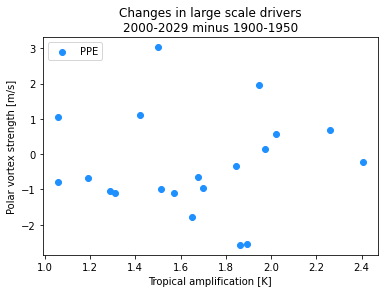

In [23]:
cmip6_models = list(set(list(cmip6_thi.keys())).intersection(list(cmip6_spv.keys())))
len(cmip6_models)

label = None
for cm in cmip6_models:
    print(cm)
    xx = deltaN(cmip6_thi[cm][50:180].data, N=30)
    yy = deltaN(cmip6_spv[cm][50:180].data, N=30)
    if cm == cmip6_models[-1]:
        label = 'CMIP6'
    plt.plot(xx, yy, 'o', color='orange', label=label)
    
plt.scatter(deltaN(Ttrop_zappa.data[:,:130], N=30), deltaN(DUstrat_zappa.data[:,:130], N=30), color='DodgerBlue', label='PPE')
plt.legend(loc='upper left')
plt.xlabel('Tropical amplification [K]')
plt.ylabel('Polar vortex strength [m/s]')
plt.title('Changes in large scale drivers\n2000-2029 minus 1900-1950')



In [24]:
# cmip6_thi[cm][50:].data[-30:].mean()

In [25]:
# # indicator = DUstrat_zappa.copy(data=numpy.apply_along_axis(gp_smoother, -1, DUstrat_zappa.data, max_length=0.8))
# # interannual_jet_posn = jet_lat.aggregated_by('season_year', iris.analysis.MEAN)                               
# # quantity = interannual_jet_posn.copy(data=numpy.apply_along_axis(gp_smoother, -1, interannual_jet_posn.data, max_length=0.8))

# period = 40.0
# indicator = DUstrat_zappa.copy(data=butterworth(DUstrat_zappa.data, period, m=20))                               
# quantity = DQtrop.copy(data=butterworth(Qtrop.data, period, m=20))
# quantity2 = DTpause.copy(data=butterworth(Tpause.data, period, m=20))



# srt = numpy.argsort(indicator.data[:,-30:].mean(-1))[::-1]


# fig = plt.figure(figsize=(10, 32))
# plt.subplots_adjust(hspace=0.8, wspace=0.5, top=0.9)
# for i0, i1 in enumerate(srt):
#     if i0 == 0:
#         prefixes = ('Polar vortex\n', 'Lower strat tropical water vapour\n', 'Tropical tropopause temperature\n')
#     else:
#         prefixes = [''] * 3
#     plt.subplot(20, 3, i0 * 3 +1)
#     xx = indicator.coord('season_year').points
#     plt.fill_between(xx, indicator.data.min(0), indicator.data.max(0), alpha=0.3, color='LightGray')
#     plt.plot(xx, indicator.data.mean(0), color='LightGray')
#     plt.plot(xx, indicator.data[i1])
#     titl = '%.4i' % (indicator.coord('realization').points[i1] - 1100000)
#     plt.title(prefixes[0] + titl)
    
#     plt.subplot(20, 3, i0 * 3 +2)
#     xx = quantity.coord('season_year').points
#     plt.fill_between(xx, quantity.data.min(0), quantity.data.max(0), alpha=0.3, color='LightGray')
#     plt.plot(xx, quantity.data.mean(0), color='LightGray')
#     plt.plot(xx, quantity.data[i1])
#     plt.title(prefixes[1] + titl)

#     plt.subplot(20, 3, i0 * 3 +3)
#     xx = quantity2.coord('season_year').points
#     plt.fill_between(xx, quantity2.data.min(0), quantity2.data.max(0), alpha=0.3, color='LightGray')
#     plt.plot(xx, quantity2.data.mean(0), color='LightGray')
#     plt.plot(xx, quantity2.data[i1])
#     plt.title(prefixes[2] + titl)

    




In [26]:
interannual_jet_posn = jet_lat.aggregated_by('season_year', iris.analysis.MEAN)
interannual_jet_str = jet_str.aggregated_by('season_year', iris.analysis.MEAN)
                               



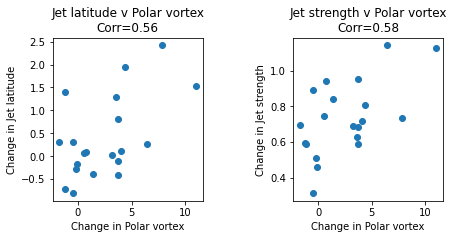

In [27]:
import matplotlib
matplotlib.rcParams['font.size'] = 10

DUstrat_zappa, interannual_jet_posn, interannual_jet_str

# def delta(x):
#     return x[:,-50:].mean(-1) - x[:,:50].mean(-1)

def plot_scatter1(xx, yy, xvar, yvar):
    p1 = plt.scatter(xx, yy)
    plt.title('%s v %s\nCorr=%.2f' % (yvar, xvar, numpy.corrcoef(xx, yy)[0,1]))
    plt.xlabel('Change in %s' % xvar)
    plt.ylabel('Change in %s' % yvar)

fig = plt.figure(figsize=(7, 3))
plt.subplots_adjust(wspace=0.6)
plt.subplot(121)
plot_scatter1(delta(DUstrat_zappa.data),
             delta(interannual_jet_posn.data[:,:199]),
            'Polar vortex', 'Jet latitude')

plt.subplot(122)
plot_scatter1(delta(DUstrat_zappa.data),
             delta(interannual_jet_str.data[:,:199]),
            'Polar vortex', 'Jet strength')




In [28]:
matplotlib.rcParams['font.size'] = 10

In [29]:
def remove_monthly_clim(cube, baseline=(1900, 1950)):
    years = cube.coord('season_year').points
    months = cube.coord('month_number').points
    d = cube.data
    anom = numpy.zeros_like(d)
    for imon in range(1, 13):
        indm = numpy.where(months == imon)[0]
        indb = numpy.where((years >= baseline[0]) & (years <= baseline[1]) & (months == imon))[0]
        clim_ = d[:,indb].mean(-1)
        anom[:,indm] = (d[:,indm].T - clim_).T
    anom = cube.copy(data=anom)
    return anom

# remove_monthly_clim(cube)

In [30]:
def get_data_noaverage(var, latlo, lathi, months='DJFMAMJJASON', numbers=list(range(12))):
    import time
    t0 = time.time()
#     var, latlo, lathi, months, numbers = 'ta850', 60, 90, 'NDJFMA', [11, 12, 1, 2, 3, 4]
    seasonal_averager = MonthMean(months)
    lat_crit = iris.Constraint(latitude=iris.util.between(latlo, lathi))
    mcrit = iris.Constraint(month_number=numbers)
    f = os.path.join(indir_zonal, 'histrcp8p5_%s_zonal.nc' % var)
    cube = iris.load_cube(f, lat_crit)
    iris.coord_categorisation.add_season_year(cube, 'time')
    cube = cube.collapsed('latitude', iris.analysis.MEAN)
    ans = remove_monthly_clim(cube)
    cube = cube.extract(mcrit)
    ans = ans.extract(mcrit)
    return ans, cube
 
NDJFMA = [11, 12, 1, 2, 3, 4]
# Tglobal_mon, Tglobal_mon = get_data_noaverage('tas', -90, 90)
DTpolar_zappa_mon, Tpolar_zappa_mon = get_data_noaverage('ta850', 60, 90, months='NDJFMA', numbers=NDJFMA)
DTtrop_zappa_mon, Ttrop_zappa_mon = get_data_noaverage('ta250', -30, 30, months='NDJFMA', numbers=NDJFMA)
DUstrat_zappa_mon, Ustrat_zappa_mon = get_data_noaverage('ua020', 70, 80, months='NDJFMA', numbers=NDJFMA)
Dqbo_mon, qbo_mon = get_data_noaverage('ua020', -10, 10, months='NDJFMA', numbers=NDJFMA)




/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn

In [31]:
# plts = plt.plot(Tpolar_zappa_mon.data.T)

In [32]:
# indicator, DUstrat_zappa, DUstrat_zappa_mon

In [33]:
# iok

/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:728: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas = numpy.linalg.lstsq(x.T, y)[0]
/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:768: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[slicer]
/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:728: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcon

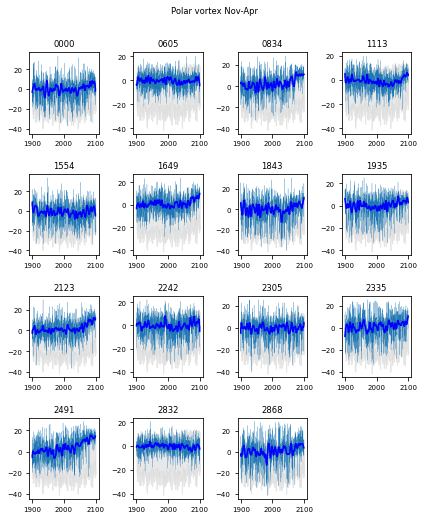

In [34]:
period = 40.0
cube = DUstrat_zappa_mon.copy()[iok]
fig = plt.figure(figsize=(174/25.4, 8))
matplotlib.rcParams['font.size'] = 7
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)
plt.suptitle('Polar vortex Nov-Apr')
lo = iris.util.rolling_window(cube.data.min(0), window=6).min(-1)
lo = numpy.concatenate((lo[[0,0,0]], lo, lo[[-1, -1]]))
hi = iris.util.rolling_window(cube.data.max(0), window=6).min(-1)
hi = numpy.concatenate((hi[[0,0,0]], hi, hi[[-1, -1]]))

for ii, (c, rn) in enumerate(zip(cube.data, cube.coord('realization').points), 1):
    plt.subplot(4, 4, ii)
    xx = numpy.arange(cube.shape[1])
    xx = cube.coord('season_year').points
    plt.fill_between(xx, lo, hi, alpha=0.5, color='LightGray')
    plt.plot(xx, c, linewidth=0.2)
    plt.plot(xx, butterworth(c, period, m=20), 'b')
    plt.title('%.4i' % (rn - 1100000))
    
fig.savefig(os.path.join(figpath, 'polar_vortex_by_member.png'), facecolor='w', dpi=300)



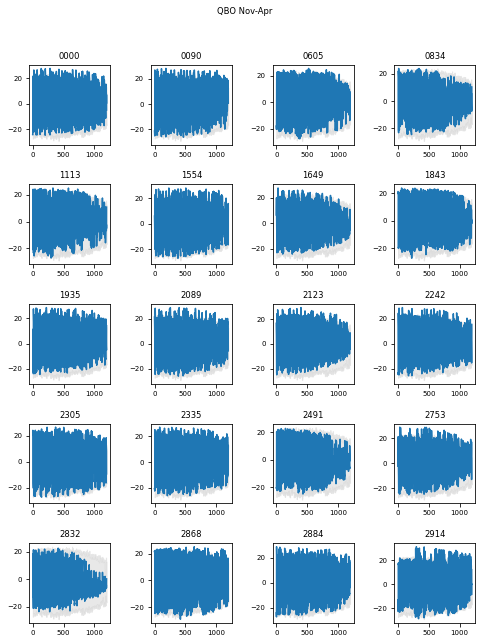

In [35]:
cube = Dqbo_mon.copy()
fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)
plt.suptitle('QBO Nov-Apr')
lo = iris.util.rolling_window(cube.data.min(0), window=6).min(-1)
lo = numpy.concatenate((lo[[0,0,0]], lo, lo[[-1, -1]]))
hi = iris.util.rolling_window(cube.data.max(0), window=6).min(-1)
hi = numpy.concatenate((hi[[0,0,0]], hi, hi[[-1, -1]]))

for ii, (c, rn) in enumerate(zip(cube.data, cube.coord('realization').points), 1):
    plt.subplot(5, 4, ii)
    xx = numpy.arange(cube.shape[1])
    plt.fill_between(xx, lo, hi, alpha=0.5, color='LightGray')
    plt.plot(c)
    plt.title('%.4i' % (rn - 1100000))
    

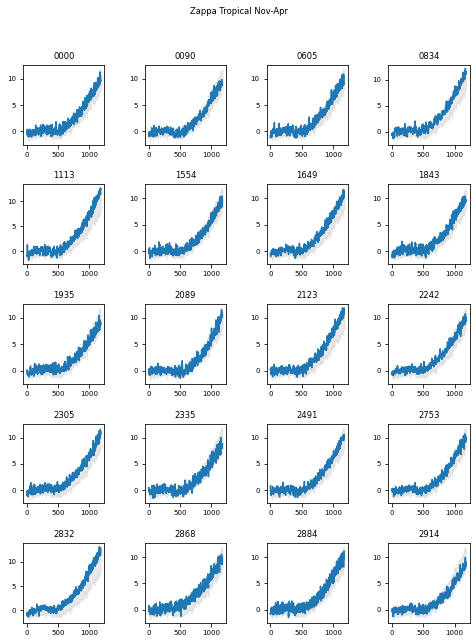

In [36]:
cube = DTtrop_zappa_mon.copy()
fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)
plt.suptitle('Zappa Tropical Nov-Apr')
lo = iris.util.rolling_window(cube.data.min(0), window=6).min(-1)
lo = numpy.concatenate((lo[[0,0,0]], lo, lo[[-1, -1]]))
hi = iris.util.rolling_window(cube.data.max(0), window=6).min(-1)
hi = numpy.concatenate((hi[[0,0,0]], hi, hi[[-1, -1]]))

for ii, (c, rn) in enumerate(zip(cube.data, cube.coord('realization').points), 1):
    plt.subplot(5, 4, ii)
    xx = numpy.arange(cube.shape[1])
    plt.fill_between(xx, lo, hi, alpha=0.5, color='LightGray')
    plt.plot(c)
    plt.title('%.4i' % (rn - 1100000))

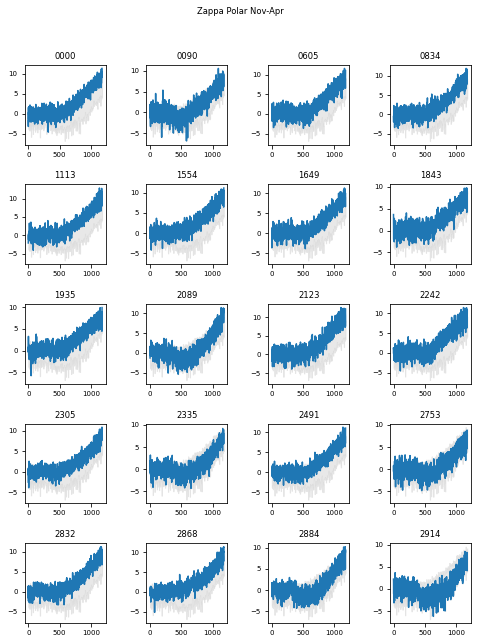

In [37]:
cube = DTpolar_zappa_mon.copy()
fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)
plt.suptitle('Zappa Polar Nov-Apr')
lo = iris.util.rolling_window(cube.data.min(0), window=6).min(-1)
lo = numpy.concatenate((lo[[0,0,0]], lo, lo[[-1, -1]]))
hi = iris.util.rolling_window(cube.data.max(0), window=6).min(-1)
hi = numpy.concatenate((hi[[0,0,0]], hi, hi[[-1, -1]]))

for ii, (c, rn) in enumerate(zip(cube.data, cube.coord('realization').points), 1):
    plt.subplot(5, 4, ii)
    xx = numpy.arange(cube.shape[1])
    plt.fill_between(xx, lo, hi, alpha=0.5, color='LightGray')
    plt.plot(c)
    plt.title('%.4i' % (rn - 1100000))

In [38]:
DTpolar_zappa_anti_mon, Tpolar_zappa_anti_mon = get_data_noaverage('ta850', -30, 30, months='NDJFMA', numbers=NDJFMA)
DTtrop_zappa_anti_mon, Ttrop_zappa_anti_mon = get_data_noaverage('ta250', 60, 90, months='NDJFMA', numbers=NDJFMA)
DTtrop_grad_mon = DTtrop_zappa_mon - DTtrop_zappa_anti_mon
DTpolar_grad_mon = DTpolar_zappa_anti_mon - DTpolar_zappa_mon

/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/opt/miniconda3/envs/py3_iris/lib/python3.8/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))


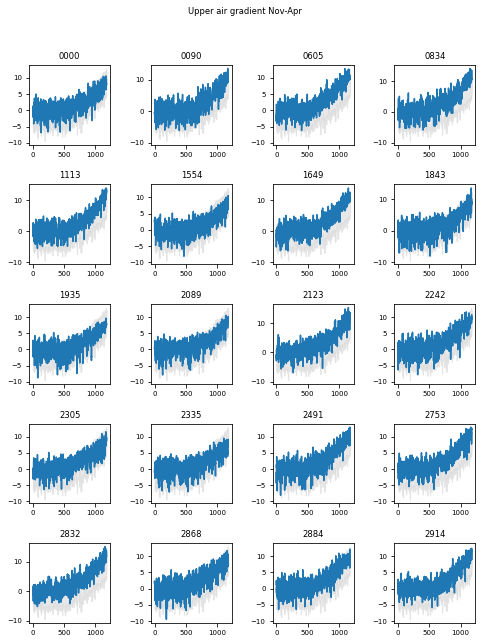

In [39]:
cube = DTtrop_grad_mon.copy()
fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)
plt.suptitle('Upper air gradient Nov-Apr')
lo = iris.util.rolling_window(cube.data.min(0), window=6).min(-1)
lo = numpy.concatenate((lo[[0,0,0]], lo, lo[[-1, -1]]))
hi = iris.util.rolling_window(cube.data.max(0), window=6).min(-1)
hi = numpy.concatenate((hi[[0,0,0]], hi, hi[[-1, -1]]))

for ii, (c, rn) in enumerate(zip(cube.data, cube.coord('realization').points), 1):
    plt.subplot(5, 4, ii)
    xx = numpy.arange(cube.shape[1])
    plt.fill_between(xx, lo, hi, alpha=0.5, color='LightGray')
    plt.plot(c)
    plt.title('%.4i' % (rn - 1100000))

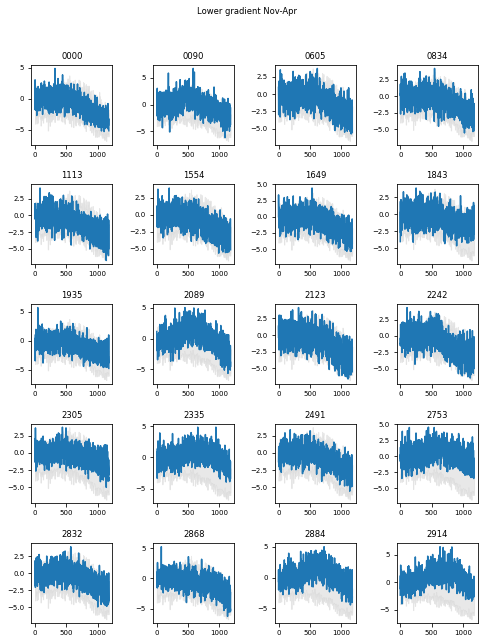

In [40]:
cube = DTpolar_grad_mon.copy()
fig = plt.figure(figsize=(8, 10))
plt.subplots_adjust(wspace=0.5, hspace=0.5, top=0.9)
plt.suptitle('Lower gradient Nov-Apr')
lo = iris.util.rolling_window(cube.data.min(0), window=6).min(-1)
lo = numpy.concatenate((lo[[0,0,0]], lo, lo[[-1, -1]]))
hi = iris.util.rolling_window(cube.data.max(0), window=6).min(-1)
hi = numpy.concatenate((hi[[0,0,0]], hi, hi[[-1, -1]]))

for ii, (c, rn) in enumerate(zip(cube.data, cube.coord('realization').points), 1):
    plt.subplot(5, 4, ii)
    xx = numpy.arange(cube.shape[1])
    plt.fill_between(xx, lo, hi, alpha=0.5, color='LightGray')
    plt.plot(c)
    plt.title('%.4i' % (rn - 1100000))

/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:728: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas = numpy.linalg.lstsq(x.T, y)[0]
/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:768: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[slicer]
/Users/davidsexton/Python/GA7/paper/qumpy_lite.py:728: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcon

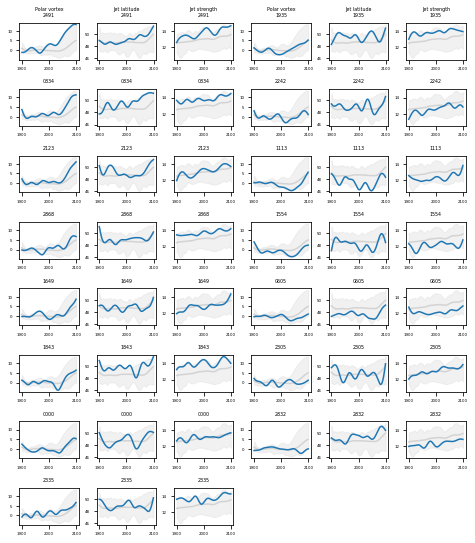

In [60]:
# indicator = DUstrat_zappa.copy(data=numpy.apply_along_axis(gp_smoother, -1, DUstrat_zappa.data, max_length=0.8))
# interannual_jet_posn = jet_lat.aggregated_by('season_year', iris.analysis.MEAN)                               
# quantity = interannual_jet_posn.copy(data=numpy.apply_along_axis(gp_smoother, -1, interannual_jet_posn.data, max_length=0.8))
# quantity2 = interannual_jet_str.copy(data=numpy.apply_along_axis(gp_smoother, -1, interannual_jet_str.data, max_length=0.8))

srt_ = [s_ for s_ in srt if s_ in iok]
period = 40.0
indicator = DUstrat_zappa.copy(data=butterworth(DUstrat_zappa.data, period, m=20))

interannual_jet_posn = jet_lat.aggregated_by('season_year', iris.analysis.MEAN)
                               
quantity = interannual_jet_posn.copy(data=butterworth(interannual_jet_posn.data, period, m=20))

interannual_jet_str = jet_str.aggregated_by('season_year', iris.analysis.MEAN)
                               
quantity2 = interannual_jet_str.copy(data=butterworth(interannual_jet_str.data, period, m=20))




DRIFTERS = [1100090, 1102089, 1102753, 1102884, 1102914, 1102305, 1102335]
fig = plt.figure(figsize=(8, 9))
matplotlib.rcParams['font.size'] = 4
plt.subplots_adjust(hspace=0.8, wspace=0.3, top=0.9)
for i0, i1 in enumerate(srt_[:8]):
    if i0 == 0:
        prefixes = ('Polar vortex\n', 'Jet latitude\n', 'Jet strength\n')
    else:
        prefixes = [''] * 3
    plt.subplot(8, 6, i0 * 6 +1)
    xx = indicator.coord('season_year').points
    plt.fill_between(xx, indicator.data.min(0), indicator.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, indicator.data.mean(0), color='LightGray')
    plt.plot(xx, indicator.data[i1])
    titl = '%.4i' % (indicator.coord('realization').points[i1] - 1100000)
    plt.title(prefixes[0] + titl, color='k' if indicator.coord('realization').points[i1] not in DRIFTERS else 'k')
    
    plt.subplot(8, 6, i0 * 6 +2)
    xx = quantity.coord('season_year').points
    plt.fill_between(xx, quantity.data.min(0), quantity.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, quantity.data.mean(0), color='LightGray')
    plt.plot(xx, quantity.data[i1])
    plt.title(prefixes[1] + titl, color='k' if indicator.coord('realization').points[i1] not in DRIFTERS else 'k')

    plt.subplot(8, 6, i0 * 6 +3)
    xx = quantity2.coord('season_year').points
    plt.fill_between(xx, quantity2.data.min(0), quantity2.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, quantity2.data.mean(0), color='LightGray')
    plt.plot(xx, quantity2.data[i1])
    plt.title(prefixes[2] + titl, color='k' if indicator.coord('realization').points[i1] not in DRIFTERS else 'k')

    

for i0, i1 in enumerate(srt_[-7:]):
    if i0 == 0:
        prefixes = ('Polar vortex\n', 'Jet latitude\n', 'Jet strength\n')
    else:
        prefixes = [''] * 3
    plt.subplot(8, 6, i0 * 6 +4)
    xx = indicator.coord('season_year').points
    plt.fill_between(xx, indicator.data.min(0), indicator.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, indicator.data.mean(0), color='LightGray')
    plt.plot(xx, indicator.data[i1])
    titl = '%.4i' % (indicator.coord('realization').points[i1] - 1100000)
    plt.title(prefixes[0] + titl, color='k' if indicator.coord('realization').points[i1] not in DRIFTERS else 'k')
    
    plt.subplot(8, 6, i0 * 6 +5)
    xx = quantity.coord('season_year').points
    plt.fill_between(xx, quantity.data.min(0), quantity.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, quantity.data.mean(0), color='LightGray')
    plt.plot(xx, quantity.data[i1])
    plt.title(prefixes[1] + titl, color='k' if indicator.coord('realization').points[i1] not in DRIFTERS else 'k')

    plt.subplot(8, 6, i0 * 6 +6)
    xx = quantity2.coord('season_year').points
    plt.fill_between(xx, quantity2.data.min(0), quantity2.data.max(0), alpha=0.3, color='LightGray')
    plt.plot(xx, quantity2.data.mean(0), color='LightGray')
    plt.plot(xx, quantity2.data[i1])
    plt.title(prefixes[2] + titl, color='k' if indicator.coord('realization').points[i1] not in DRIFTERS else 'k')

fig.savefig(os.path.join(figpath, 'polar_vortex_v_jets_by_member_no_drifters.png'), facecolor='w', dpi=300)





-9.485604133605959 7.6251792716979985
0.024120370370370372
0.014074074074074076
1.0 1.0
-0.28876360654830935 0.40641515851020815
0.02148148148148148
0.004351851851851853
1.0 1.0
-1.1616395330429077 1.0140129470825197
0.022407407407407407
0.003611111111111112
0.9999999999999999 1.0
-17.06967674255371 20.22402946472168
0.021805555555555557
0.0025000000000000005
1.0 0.9999999999999999


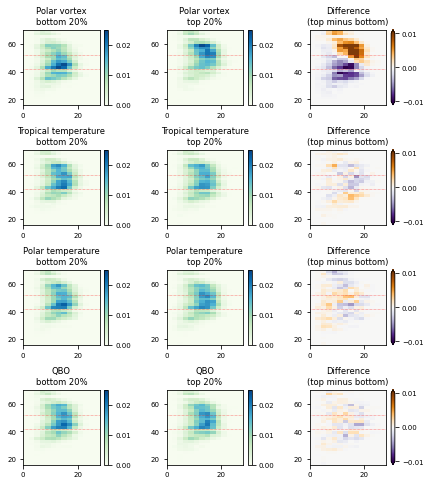

In [41]:
def plot_index_composite(cube, titl, vmax=None, prob=.2, nrow=1, row=1):

    # cube = DUstrat_zappa_mon.copy()
    # cube
    
    jet_str_ = jet_str[iok]
    jet_lat_ = jet_lat[iok]
    
    indy = numpy.where((cube.coord('season_year').points >= 1901) & (cube.coord('season_year').points <= 1980))[0]
    base = cube[:,indy]
    if not base.coords('year'):
        iris.coord_categorisation.add_year(base, 'time')
    # jet_lat
    yrb = base.coord('year').points
    mnb = base.coord('month_number').points

    ivals = numpy.zeros((base.shape[0], base.shape[-1], 30))
    lvals = numpy.zeros((base.shape[0], base.shape[-1], 30))
    svals = numpy.zeros((base.shape[0], base.shape[-1], 30))


    n1 = 0
    for j in range(base.shape[-1]):
        yyyymm='%.4i%.2i' % (yrb[j], mnb[j])
        yyyymmdd = jet_lat.coord('yyyymmdd').points.tolist()
        indj = [ymd.startswith(yyyymm) for ymd in yyyymmdd]
        if numpy.sum(indj) == 30:
            for ii in range(30):
                ivals[:,n1,ii] = base.data[:,j]
            lvals[:,n1,:] = jet_lat_.data[:,indj]
            svals[:,n1,:] = jet_str_.data[:,indj]
            n1 += 1

    ivals = ivals[:,:n1,:]
    lvals = lvals[:,:n1,:]
    svals = svals[:,:n1,:]


    jl20 = numpy.array([])
    js20 = numpy.array([])
    jl80 = numpy.array([])
    js80 = numpy.array([])
    for rn in range(base.shape[0]):
        p20, p80 = scipy.stats.mstats.mquantiles(ivals[rn,:,0], prob=[prob, 1.0 - prob])
        if rn == 0: print(p20, p80)
        i20 = numpy.where(ivals[rn,:,0] <= p20)[0]
        i80 = numpy.where(ivals[rn,:,0] >= p80)[0]
        jl20 = numpy.concatenate((jl20, lvals[rn,i20,:].ravel()))
        jl80 = numpy.concatenate((jl80, lvals[rn,i80,:].ravel()))
        js20 = numpy.concatenate((js20, svals[rn,i20,:].ravel()))
        js80 = numpy.concatenate((js80, svals[rn,i80,:].ravel()))

    jet_str_edges = strbin = numpy.linspace(0, 28, num=15)
    jet_lat_edges = latbin = numpy.linspace(16, 70, num=28)

#     fig = plt.figure(figsize=(8, 4))
    plt.subplot(nrow, 3, (row-1)*3+1)
    freq1, _x1, _y1, _binnumber1 = scipy.stats.binned_statistic_2d(jl20, js20, js20,
                                                               bins=(latbin, strbin),
                                                               statistic='count')

    freq1 /= freq1.sum()
    plt.pcolormesh(_y1, _x1, freq1, vmin=0, vmax=vmax, cmap='GnBu')
    plt.axhline(y=52, color='r', linestyle=':', linewidth=0.5)
    plt.axhline(y=42, color='r', linestyle=':', linewidth=0.5)
    plt.title('%s\nbottom %.2i%%' % (titl, prob*100))
    plt.colorbar()

    plt.subplot(nrow, 3, (row-1)*3+2)
    freq2, _x2, _y2, _binnumber2 = scipy.stats.binned_statistic_2d(jl80, js80, js80,
                                                               bins=(latbin, strbin),
                                                               statistic='count')
    freq2 /= freq2.sum()
    print(freq1.max())

    plt.pcolormesh(_y1, _x1, freq2, vmin=0, vmax=vmax, cmap='GnBu')
    plt.axhline(y=52, color='r', linestyle=':', linewidth=0.5)
    plt.axhline(y=42, color='r', linestyle=':', linewidth=0.5)
    plt.title('%s\ntop %.2i%%' % (titl, prob*100))
    plt.colorbar()

    print((freq2 - freq1).max())
    plt.subplot(nrow, 3, (row-1)*3+3)
    plt.pcolormesh(_y1, _x1, freq2 - freq1, vmin=-vmax/2.5, vmax=vmax/2.5, cmap='PuOr_r')
    plt.axhline(y=52, color='r', linestyle=':', linewidth=0.5)
    plt.axhline(y=42, color='r', linestyle=':', linewidth=0.5)
    plt.title('Difference\n(top minus bottom)')
    plt.colorbar(extend='both')


    print(freq1.sum(), freq2.sum())


fig = plt.figure(figsize=(174/25.4, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.6)
matplotlib.rcParams['font.size'] = 7
vmax = 0.025
plot_index_composite(DUstrat_zappa_mon[iok], 'Polar vortex', nrow=4, row=1, prob=0.2, vmax=vmax)
plot_index_composite(DTtrop_zappa_mon[iok], 'Tropical temperature', prob=0.2, vmax=vmax, nrow=4, row=2)
plot_index_composite(DTpolar_zappa_mon[iok], 'Polar temperature', prob=0.2, vmax=vmax, nrow=4, row=3)
plot_index_composite(Dqbo_mon[iok], 'QBO', prob=0.2, vmax=vmax, nrow=4, row=4)


matplotlib.rcParams['font.size'] = 10

fig.savefig(os.path.join(figpath, 'jet_large_scale_drivers.png'), dpi=300)




[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 0.4628193429639775 0.521978021978022
[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 0.3074872189328532 0.5
[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 0.29940522879455844 0.33516483516483514
[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 0.2808969485134134 0.2967032967032967
[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 0.43834329272855377 0.22527472527472525
[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 0.7566810353566101 0.6813186813186813
[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 -0.6252123625340794 -0.4505494505494505
[0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17] 20 20 -0.4816606601562157 -0.33516483516483514


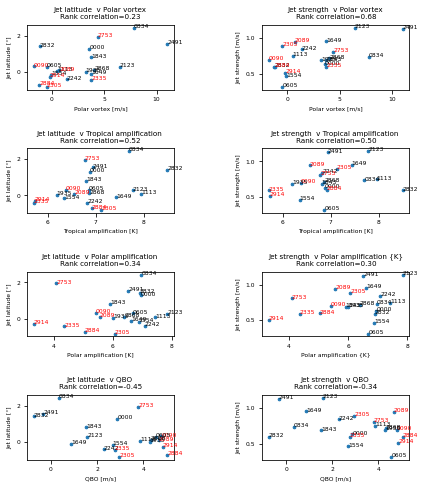

In [42]:
def plot_scatter4(xxx, yyy, xlabel, ylabel, titl=''):
    iok = [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17]
    iok = [0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17]
    DROP = [1100090, 1102753, 1102884, 1102914, 1102089, 1102305, 1102335]

    plt.scatter(xxx, yyy, s=7)
    realns = numpy.array([1100000, 1100090, 1100605, 1100834, 1101113, 1101554, 1101649,
       1101843, 1101935, 1102089, 1102123, 1102242, 1102305, 1102335,
       1102491, 1102753, 1102832, 1102868, 1102884, 1102914])
    for xx, yy, rn in zip(xxx, yyy, realns):
        plt.text(xx, yy, '%.4i' % (rn - 1100000), color='r' if rn in DROP else 'k', fontsize=6)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    corr = numpy.corrcoef(xxx, yyy)[0,1]
    corr13 = numpy.corrcoef(xxx[iok], yyy[iok])[0,1]
    spearmanr = scipy.stats.spearmanr(xxx, yyy)[0]
    spearmanr13 = scipy.stats.spearmanr(xxx[iok], yyy[iok])[0]
    print(iok, xxx.size, yyy.size, corr13, spearmanr13)


    if titl:
        titl += '\n'
#     plt.title('%s v %s\ncorr=%.2f (%.2f for the 13)\nSpearmanr=%.2f (%.2f for the 13)' % (ylabel, xlabel, corr, corr13, spearmanr, spearmanr13))
#     plt.title('%s v %s\nSpearmanr=%.2f (%.2f for the 13)' % (ylabel.split('[')[0], xlabel.split('[')[0], spearmanr, spearmanr13))
    plt.title('%s v %s\nRank correlation=%.2f' % (ylabel.split('[')[0], xlabel.split('[')[0], spearmanr13))




fig = plt.figure(figsize=(174/25.4, 8))
plt.subplots_adjust(wspace=0.6, hspace=0.9)
matplotlib.rcParams['font.size'] = 6
plt.subplot(423)
plot_scatter4(delta(DTtrop_zappa.data),
             delta(interannual_jet_posn.data[:,:199]),
            'Tropical amplification [K]', u'Jet latitude [\u00b0]')

plt.subplot(424)
plot_scatter4(delta(DTtrop_zappa.data),
             delta(interannual_jet_str.data[:,:199]),
            'Tropical amplification [K]', 'Jet strength [m/s]')

plt.subplot(425)
plot_scatter4(delta(DTpolar_zappa.data),
             delta(interannual_jet_posn.data[:,:199]),
            'Polar amplification [K]', u'Jet latitude [\u00b0]')

plt.subplot(426)
plot_scatter4(delta(DTpolar_zappa.data),
             delta(interannual_jet_str.data[:,:199]),
            'Polar amplification {K}', 'Jet strength [m/s]')

plt.subplot(421)
plot_scatter4(delta(DUstrat_zappa.data),
             delta(interannual_jet_posn.data[:,:199]),
            'Polar vortex [m/s]', u'Jet latitude [\u00b0]')

plt.subplot(422)
plot_scatter4(delta(DUstrat_zappa.data),
             delta(interannual_jet_str.data[:,:199]),
            'Polar vortex [m/s]', 'Jet strength [m/s]')

plt.subplot(427)
plot_scatter4(delta(Dqbo.data),
             delta(interannual_jet_posn.data[:,:199]),
            'QBO [m/s]', u'Jet latitude [\u00b0]')

plt.subplot(428)
plot_scatter4(delta(Dqbo.data),
             delta(interannual_jet_str.data[:,:199]),
            'QBO [m/s]', 'Jet strength [m/s]')



matplotlib.rcParams['font.size'] = 10

[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.4628193429639775 0.521978021978022
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.3074872189328532 0.5
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.29940522879455844 0.33516483516483514
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.2808969485134134 0.2967032967032967
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.43834329272855377 0.22527472527472525
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.7566810353566101 0.6813186813186813
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 -0.6252123625340794 -0.4505494505494505
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 -0.4816606601562157 -0.33516483516483514


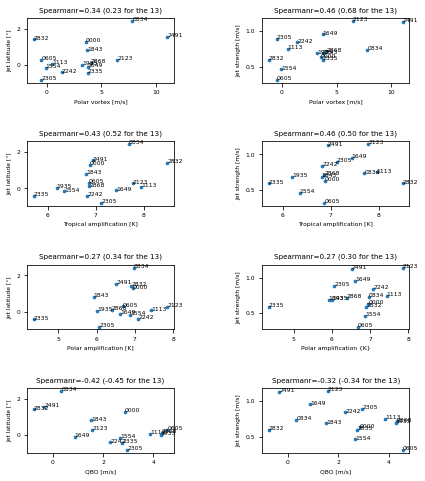

In [43]:
def plot_scatter3(xxx, yyy, xlabel, ylabel, titl='', labelsize=6):
    iok1 = [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17]
    iok2 = [0, 2, 3, 4, 5, 6, 7, 8, 10, 13, 14, 16, 17]
    DROP = [] #1102305, 1102335]

    plt.scatter(xxx[iok1], yyy[iok1], s=7)
    realns = numpy.array([1100000, 1100090, 1100605, 1100834, 1101113, 1101554, 1101649,
       1101843, 1101935, 1102089, 1102123, 1102242, 1102305, 1102335,
       1102491, 1102753, 1102832, 1102868, 1102884, 1102914])
    for xx, yy, rn in zip(xxx[iok1], yyy[iok1], realns[iok]):
        plt.text(xx, yy, '%.4i' % (rn - 1100000), color='r' if rn in DROP else 'k', fontsize=labelsize)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    corr = numpy.corrcoef(xxx[iok1], yyy[iok1])[0,1]
    corr13 = numpy.corrcoef(xxx[iok2], yyy[iok2])[0,1]
    spearmanr = scipy.stats.spearmanr(xxx[iok1], yyy[iok1])[0]
    spearmanr13 = scipy.stats.spearmanr(xxx[iok2], yyy[iok2])[0]
    print(iok, xxx.size, yyy.size, corr13, spearmanr13)


    if titl:
        titl += '\n'
#     plt.title('%s v %s\ncorr=%.2f (%.2f for the 13)\nSpearmanr=%.2f (%.2f for the 13)' % (ylabel, xlabel, corr, corr13, spearmanr, spearmanr13))
    plt.title('%sSpearmanr=%.2f (%.2f for the 13)' % (titl, spearmanr, spearmanr13))
#     plt.title('%s v %s\nRank correlation=%.2f' % (ylabel.split('[')[0], xlabel.split('[')[0], spearmanr13))




fig = plt.figure(figsize=(174/25.4, 8))
plt.subplots_adjust(wspace=0.6, hspace=0.9)
matplotlib.rcParams['font.size'] = 6
plt.subplot(423)
plot_scatter3(delta(DTtrop_zappa.data),
             delta(interannual_jet_posn.data[:,:199]),
            'Tropical amplification [K]', u'Jet latitude [\u00b0]')

plt.subplot(424)
plot_scatter3(delta(DTtrop_zappa.data),
             delta(interannual_jet_str.data[:,:199]),
            'Tropical amplification [K]', 'Jet strength [m/s]')

plt.subplot(425)
plot_scatter3(delta(DTpolar_zappa.data),
             delta(interannual_jet_posn.data[:,:199]),
            'Polar amplification [K]', u'Jet latitude [\u00b0]')

plt.subplot(426)
plot_scatter3(delta(DTpolar_zappa.data),
             delta(interannual_jet_str.data[:,:199]),
            'Polar amplification {K}', 'Jet strength [m/s]')

plt.subplot(421)
plot_scatter3(delta(DUstrat_zappa.data),
             delta(interannual_jet_posn.data[:,:199]),
            'Polar vortex [m/s]', u'Jet latitude [\u00b0]')

plt.subplot(422)
plot_scatter3(delta(DUstrat_zappa.data),
             delta(interannual_jet_str.data[:,:199]),
            'Polar vortex [m/s]', 'Jet strength [m/s]')

plt.subplot(427)
plot_scatter3(delta(Dqbo.data),
             delta(interannual_jet_posn.data[:,:199]),
            'QBO [m/s]', u'Jet latitude [\u00b0]')

plt.subplot(428)
plot_scatter3(delta(Dqbo.data),
             delta(interannual_jet_str.data[:,:199]),
            'QBO [m/s]', 'Jet strength [m/s]')

fig.savefig(os.path.join(figpath, 'jet_large_scale_drivers_emergent.png'), dpi=300)


matplotlib.rcParams['font.size'] = 10

(15, 480) (15, 17970)
-31.663549423217773 -9.485604133605959
-9.485604133605959 -0.8936402368545531
-0.8936402368545531 3.7052883243560792
3.7052883243560792 7.6251792716979985
7.6251792716979985 25.71347999572754
(15, 480) (15, 17970)
-31.663549423217773 -9.485604133605959
-9.485604133605959 -0.8936402368545531
-0.8936402368545531 3.7052883243560792
3.7052883243560792 7.6251792716979985
7.6251792716979985 25.71347999572754
-9.485604133605959 7.6251792716979985
0.024120370370370372
0.014074074074074076
1.0 1.0


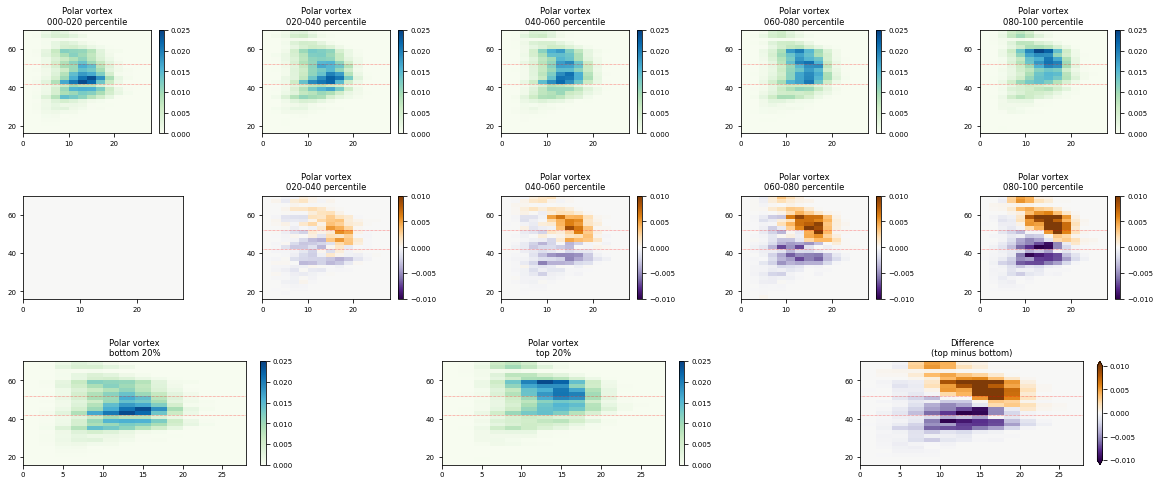

In [44]:
def plot_index_composite5(cube, titl, vmax=None, prob=.2, nrow=1, row=1, diff=False):

    # cube = DUstrat_zappa_mon.copy()
    # cube
    
    jet_lat_ = jet_lat[iok]
    jet_str_ = jet_str[iok]
    
    indy = numpy.where((cube.coord('season_year').points >= 1901) & (cube.coord('season_year').points <= 1980))[0]
    base = cube[:,indy]
    if not base.coords('year'):
        iris.coord_categorisation.add_year(base, 'time')
    # jet_lat
    yrb = base.coord('year').points
    mnb = base.coord('month_number').points

    ivals = numpy.zeros((base.shape[0], base.shape[-1], 30))
    lvals = numpy.zeros((base.shape[0], base.shape[-1], 30))
    svals = numpy.zeros((base.shape[0], base.shape[-1], 30))


    print(base.shape, jet_lat_.shape)
    n1 = 0
    for j in range(base.shape[-1]):
        yyyymm='%.4i%.2i' % (yrb[j], mnb[j])
        yyyymmdd = jet_lat.coord('yyyymmdd').points.tolist()
        indj = [ymd.startswith(yyyymm) for ymd in yyyymmdd]
        if numpy.sum(indj) == 30:
            for ii in range(30):
                ivals[:,n1,ii] = base.data[:,j]
            lvals[:,n1,:] = jet_lat_.data[:,indj]
            svals[:,n1,:] = jet_str_.data[:,indj]
            n1 += 1

    ivals = ivals[:,:n1,:]
    lvals = lvals[:,:n1,:]
    svals = svals[:,:n1,:]


    probval = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

    for ip, (plo, phi) in enumerate(zip(probval[:5], probval[1:]), 1):

        jl20 = numpy.array([])
        js20 = numpy.array([])
        jl80 = numpy.array([])
        js80 = numpy.array([])

        for rn in range(base.shape[0]):
            lo, hi = scipy.stats.mstats.mquantiles(ivals[rn,:,0], prob=[plo, phi])
            if rn == 0: print(lo, hi)
            i20 = numpy.where((ivals[rn,:,0] >= lo) & (ivals[rn,:,0] < hi))[0]
            jl20 = numpy.concatenate((jl20, lvals[rn,i20,:].ravel()))
            js20 = numpy.concatenate((js20, svals[rn,i20,:].ravel()))

        jet_str_edges = strbin = numpy.linspace(0, 28, num=15)
        jet_lat_edges = latbin = numpy.linspace(16, 70, num=28)

    #     fig = plt.figure(figsize=(8, 4))
        plt.subplot(nrow, 5, (row-1)*5+ip)
        freq1, _x1, _y1, _binnumber1 = scipy.stats.binned_statistic_2d(jl20, js20, js20,
                                                                   bins=(latbin, strbin),
                                                                   statistic='count')
        
        if ip == 1:
            freq_base = freq1.copy() / freq1.sum()

        freq1 /= freq1.sum()
        if diff:
            plt.pcolormesh(_y1, _x1, freq1 - freq_base, vmin=-vmax/2.5, vmax=vmax / 2.5, cmap='PuOr_r')
        else:
            plt.pcolormesh(_y1, _x1, freq1, vmin=0, vmax=vmax, cmap='GnBu')
        if ip != 1 or not diff:
            plt.axhline(y=52, color='r', linestyle=':', linewidth=0.5)
            plt.axhline(y=42, color='r', linestyle=':', linewidth=0.5)
            plt.title('%s\n%.3i-%.3i percentile' % (titl, probval[ip-1] * 100, probval[ip]*100))
            plt.colorbar()



fig = plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.6)
matplotlib.rcParams['font.size'] = 7
vmax = 0.025
plot_index_composite5(DUstrat_zappa_mon[iok], 'Polar vortex', nrow=3, row=1, vmax=vmax)
plot_index_composite5(DUstrat_zappa_mon[iok], 'Polar vortex', nrow=3, row=2, vmax=vmax, diff=True)
plot_index_composite(DUstrat_zappa_mon[iok], 'Polar vortex', nrow=3, row=3, vmax=vmax)

# plot_index_composite(DTtrop_zappa_mon, 'Tropical temperature', prob=0.2, vmax=vmax, nrow=4, row=2)
# plot_index_composite(DTpolar_zappa_mon, 'Polar temperature', prob=0.2, vmax=vmax, nrow=4, row=3)
# plot_index_composite(Dqbo_mon, 'QBO', prob=0.2, vmax=vmax, nrow=4, row=4)


matplotlib.rcParams['font.size'] = 10





(15, 480) (15, 17970)
-6.906506061553955 -1.474859447479248
-1.474859447479248 -0.13843181550502776
-0.13843181550502776 0.6768609905242919
0.6768609905242919 1.504693775177002
1.504693775177002 4.171985149383545
(15, 480) (15, 17970)
-6.906506061553955 -1.474859447479248
-1.474859447479248 -0.13843181550502776
-0.13843181550502776 0.6768609905242919
0.6768609905242919 1.504693775177002
1.504693775177002 4.171985149383545
-1.474859447479248 1.504693775177002
0.023148148148148147
0.014814814814814815
1.0 1.0


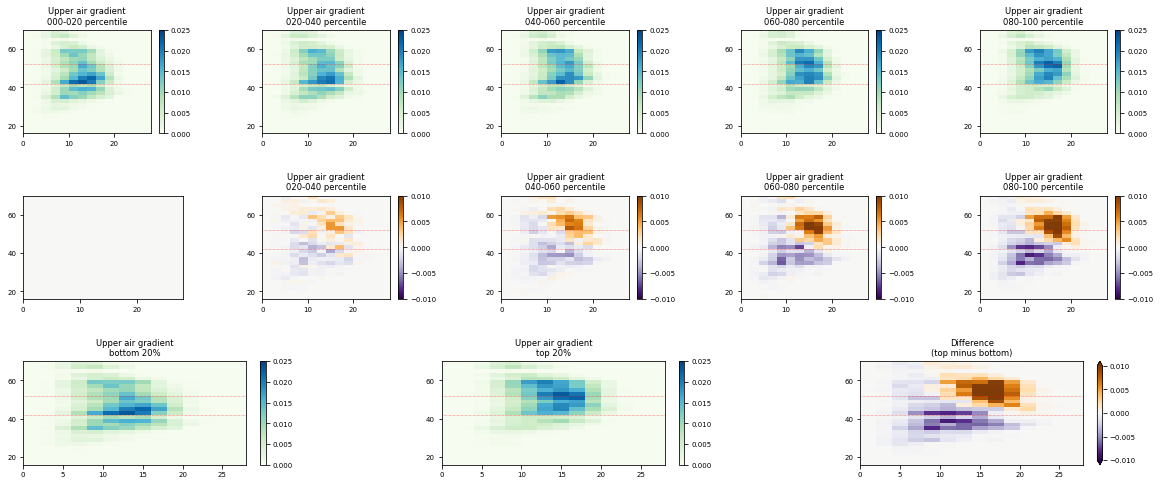

In [45]:
fig = plt.figure(figsize=(20, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.6)
matplotlib.rcParams['font.size'] = 7
vmax = 0.025

plot_index_composite5(DTtrop_grad_mon[iok], 'Upper air gradient', nrow=3, row=1, vmax=vmax)
plot_index_composite5(DTtrop_grad_mon[iok], 'Upper air gradient', nrow=3, row=2, vmax=vmax, diff=True)
plot_index_composite(DTtrop_grad_mon[iok], 'Upper air gradient', nrow=3, row=3, vmax=vmax)

matplotlib.rcParams['font.size'] = 10




Check weather types
====================

In [46]:
cachedir = os.path.join(tempdir, 'cache/wt_jets')
fcache_wts = os.path.join(cachedir, 'wts_djf.dat')
wtypes, wt_ann = cacheLoad(fcache_wts)

wtypes, wt_ann

/Users/davidsexton/Data/papers/uk_winter_precip/Temp/cache/wt_jets/wts_djf.dat is up to date and cache being restored


(<iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 18000)>,
 {'wt1': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>,
  'wt2': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>,
  'wt3': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>,
  'wt4': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>,
  'wt5': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>,
  'wt6': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>,
  'wt7': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>,
  'wt8': <iris 'Cube' of air_pressure_at_sea_level / (1) (realization: 20; time: 200)>})

In [47]:
# fig = plt.figure(figsize=(174/25.4, 7))
# matplotlib.rcParams['font.size'] = 6
# plt.subplots_adjust(wspace=0.5, hspace=0.9)
# for i in range(1, 9):
#     iwt = 'wt%.1i' % i
#     uwt = iwt.upper()
#     plt.subplot(4, 2, i)
#     plot_scatter(numpy.array(ens.gwd_frc.values), delta(wt_ann[iwt].data), 
#                 'GWD_FRC', 'Change in %s' % uwt, '%s v GWD_FRC' % uwt)
    
# matplotlib.rcParams['font.size'] = 10



[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 -0.7834788573761379 -0.8351648351648352
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.793507128786623 0.7032967032967032
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 -0.7269784461422752 -0.6593406593406593
[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17] 20 20 0.6633907734968315 0.7125178680055446


/var/folders/8h/3r2d3cgx24ndq8gpzzplllcr0000gn/T/ipykernel_47881/1051752471.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "faceolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(os.path.join(figpath, 'top4_wtypes_large_scale_drivers_emergent.png'), faceolor='w', dpi=300)


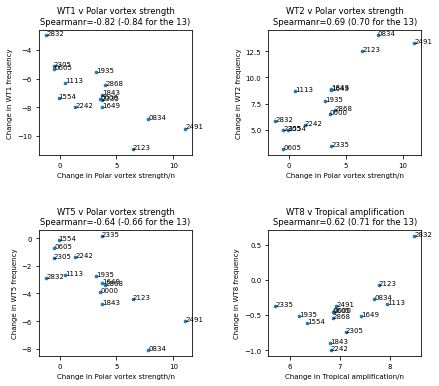

In [48]:
triplets = (('Polar vortex strength', DUstrat_zappa.data, 1),
            ('Polar vortex strength', DUstrat_zappa.data, 2),
            ('Polar vortex strength', DUstrat_zappa.data, 5),
            ('Tropical amplification', DTtrop_zappa.data, 8))

fig = plt.figure(figsize=(174/25.4, 6))
matplotlib.rcParams['font.size'] = 7
plt.subplots_adjust(wspace=0.5, hspace=0.6)
for ii, (titl, yvals, i) in enumerate(triplets, 1):
    iwt = 'wt%.1i' % i
    uwt = iwt.upper()
    plt.subplot(2, 2, ii)
    plot_scatter3(delta(yvals), delta(wt_ann[iwt].data), 
                'Change in %s/n' % titl, 'Change in %s frequency' % uwt, '%s v %s' % (uwt, titl), labelsize=7)
    
matplotlib.rcParams['font.size'] = 10
fig.savefig(os.path.join(figpath, 'top4_wtypes_large_scale_drivers_emergent.png'), faceolor='w', dpi=300)
fig.savefig(os.path.join(figpath, 'Fig10.png'), facecolor='w', dpi=300)
fig.savefig(os.path.join(figpath, 'Fig10.tiff'), facecolor='w', dpi=300)




